In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import re

# Adjust the path to point to your project root.
project_root = os.path.abspath('/Users/treycole/Repos/axion-pert')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from modules.qe_read_file import (
    read_w90_band_dat, read_labelinfo, read_bands_gnu, get_symmetry_kpath_labels,
    read_bands_dat_filband, kpath_distance ,plot_bands
)

In [2]:
# def plot_bands(
#         E: np.ndarray,
#         kpts: np.ndarray,
#         segments: list[int],
#         labels: list[str],
#         ef: float | None = None,
#         ylim: tuple[float, float] | None = None,
#         title: str | None = None, outfile: str | None = None):
#     """
#     Plot bands vs k-point index.

#     Parameters
#     ----------
#     E : (nks, nbnd) array
#     ef : float or None
#         If given, subtract this Fermi level (eV).
#     ylim : (ymin, ymax) or None
#     title : str or None
#     outfile : str or None
#         If provided, save to this path; otherwise just show.
#     """
#     fig, ax = plt.subplots()

#     nks, nbnd = E.shape
#     k = kpts
#     assert len(k) == nks, "kpts length must match E.shape[0]"
#     Y = E if ef is None else (E - ef)

#     # Get high-symmetry k-path labels
#     xticks, xlabels = get_symmetry_kpath_labels(kpts, segments, labels)

#     # Set high-symmetry k-path labels
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xlabels)
#     for x in xticks:
#         ax.axvline(x, color='gray', lw=0.5, ls='-')

#     for j in range(nbnd):
#         ax.plot(k, Y[:, j], color='b', lw=0.7)

#     # Fermi level
#     if ef is not None:
#         ax.axhline(0, color='k', lw=0.5, ls='--')
#         ax.set_ylabel(r"Energy − $E_F$ (eV)")
#     else:
#         ax.set_ylabel("Energy (eV)")   

#     ax.set_xlabel("k-point index along path")
#     ax.set_xlim(k[0], k[-1])

#     if ylim: 
#         ax.set_ylim(*ylim)

#     ax.set_title(title or f"Band structure ({nbnd} bands, {nks} k-points)")
#     return fig, ax

In [3]:
E_F = 7.6740 # eV

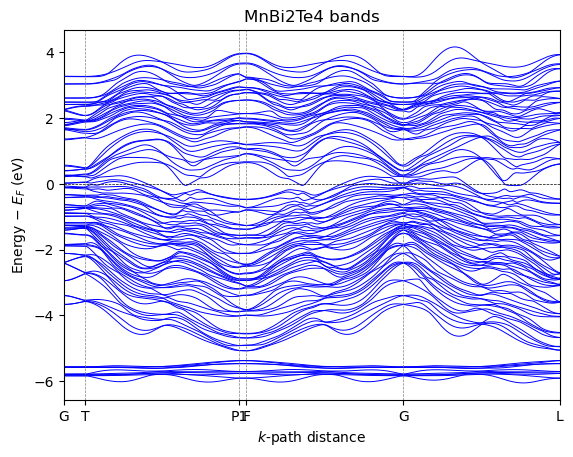

In [4]:
x, E = read_w90_band_dat("MnBi2Te4_band.dat")
labels = read_labelinfo("MnBi2Te4_band.labelinfo.dat")
fig, ax = plot_bands(x, E, labels, ef=E_F, title="MnBi2Te4 bands")

In [5]:
import numpy as np
from pathlib import Path

def read_amn(path):
    """
    Robust parser for Wannier90 .amn files.

    Returns
    -------
    A : np.ndarray, complex128, shape = (nk, nbnd, nproj)
        A[k, m, n] = <psi_{m,k} | g_n>.
    kpoints : list[tuple[float,float,float]] or None
        k-points in crystal coords (only for block format that lists them).
    meta : dict
        {'header': (nbnd_h, nproj_h, nk_h), 'inferred': (nbnd, nproj, nk), 'layout': 'row'|'block'}
    """
    def decomment(s: str) -> str:
        return s.split('!')[0].split('#')[0].strip()

    def is_int(s: str) -> bool:
        try: int(s); return True
        except: return False

    def is_float(s: str) -> bool:
        try: float(s); return True
        except: return False

    lines = [decomment(L) for L in Path(path).read_text().splitlines()]
    lines = [L for L in lines if L]

    # Find the first line with three positive ints (wannier header), but don't fully trust it
    nbnd_h = nproj_h = nk_h = None
    header_idx = None
    for i, L in enumerate(lines):
        parts = L.split()
        if len(parts) >= 3:
            try:
                a, b, c = map(int, parts[:3])
                if a > 0 and b > 0 and c > 0:
                    nbnd_h, nproj_h, nk_h = a, b, c
                    header_idx = i
                    break
            except ValueError:
                pass
    if header_idx is None:
        raise ValueError("Could not locate the 'nbnd nproj nk' header in .amn")

    # Detect layout using a few lines after the header
    sample = []
    for L in lines[header_idx+1 : header_idx+1+20]:
        parts = L.split()
        if parts:
            sample.append(parts)

    has_row_layout = any(
        len(p) >= 5 and is_int(p[0]) and is_int(p[1]) and is_int(p[2]) and is_float(p[3]) and is_float(p[4])
        for p in sample
    )

    if has_row_layout:
        # ---- ROW LAYOUT: each data line = m n ik Re Im ----
        rows = []
        max_m = max_n = max_ik = 0
        for L in lines[header_idx+1:]:
            parts = L.split()
            if len(parts) >= 5 and is_int(parts[0]) and is_int(parts[1]) and is_int(parts[2]) and is_float(parts[3]) and is_float(parts[4]):
                m = int(parts[0]); n = int(parts[1]); ik = int(parts[2])
                re = float(parts[3]); im = float(parts[4])
                rows.append((ik, m, n, re, im))
                if m   > max_m:  max_m  = m
                if n   > max_n:  max_n  = n
                if ik  > max_ik: max_ik = ik

        # Infer true dims from the data (this resolves swapped nk/nproj)
        nbnd, nproj, nk = max_m, max_n, max_ik

        A = np.zeros((nk, nbnd, nproj), dtype=np.complex128)
        for ik, m, n, re, im in rows:
            A[ik-1, m-1, n-1] = re + 1j*im

        return A, None, {"header": (nbnd_h, nproj_h, nk_h), "inferred": (nbnd, nproj, nk), "layout": "row"}

    # ---- BLOCK LAYOUT: optional 'kx ky kz' line, then nbnd*nproj lines of m n Re Im ----
    nbnd, nproj, nk = nbnd_h, nproj_h, nk_h  # block format usually has correct header
    A = np.zeros((nk, nbnd, nproj), dtype=np.complex128)
    kpoints = []
    i = header_idx + 1
    k = 0
    count = 0

    while i < len(lines) and k < nk:
        parts = lines[i].split()

        # optional k-vector line (3 floats, optional weight)
        if count == 0 and len(parts) in (3, 4) and all(is_float(x) for x in parts[:3]):
            kpoints.append(tuple(float(x) for x in parts[:3]))
            i += 1
            continue

        # projection line: m n Re Im
        if len(parts) >= 4 and is_int(parts[0]) and is_int(parts[1]) and is_float(parts[2]) and is_float(parts[3]):
            m = int(parts[0]); n = int(parts[1]); re = float(parts[2]); im = float(parts[3])
            if not (1 <= m <= nbnd and 1 <= n <= nproj):
                raise ValueError(f"Index out of range at k={k+1}: m={m}, n={n} (nbnd={nbnd}, nproj={nproj})")
            A[k, m-1, n-1] = re + 1j*im
            count += 1
            if count == nbnd * nproj:
                k += 1
                count = 0
            i += 1
            continue

        i += 1

    if k != nk:
        raise ValueError(f"Incomplete .amn: parsed {k} of {nk} k-point blocks.")

    if len(kpoints) != nk:
        kpoints = None

    return A, kpoints, {"header": (nbnd_h, nproj_h, nk_h), "inferred": (nbnd, nproj, nk), "layout": "block"}

In [6]:
# Example usage:
A, kpts, info = read_amn("MnBi2Te4.amn")
# A.shape -> (nk, nbnd, nproj); e.g. A[ik, m, n] is <psi_{m,k} | g_n>

In [7]:
V, S, W = np.linalg.svd(A)

In [8]:
S.shape

(64, 92)

In [9]:
np.where(S > 1)[0].shape[0]/64

20.0

In [10]:
S[0]

array([1.64857336, 1.6485583 , 1.64777948, 1.6477073 , 1.63879521,
       1.63875764, 1.63612912, 1.63601996, 1.63338779, 1.63335693,
       1.62136968, 1.62111072, 1.61678428, 1.61596761, 1.60899902,
       1.60840488, 1.59870536, 1.59833681, 1.59388095, 1.59362184,
       0.80317826, 0.80313082, 0.79879252, 0.79875412, 0.78963571,
       0.78956728, 0.78019299, 0.78015868, 0.76966632, 0.76961563,
       0.76592791, 0.76591589, 0.76332039, 0.76329291, 0.75723014,
       0.75719732, 0.75686778, 0.75682668, 0.75649693, 0.75647668,
       0.75647066, 0.75632119, 0.75620635, 0.75609559, 0.74780849,
       0.74779236, 0.7477636 , 0.74747204, 0.74735489, 0.74728251,
       0.74705307, 0.74669477, 0.73360575, 0.73358366, 0.73041584,
       0.73031927, 0.72997243, 0.7299316 , 0.7265339 , 0.72651668,
       0.72352173, 0.72327243, 0.72291278, 0.72285105, 0.72066387,
       0.72035658, 0.71578474, 0.71545689, 0.68457561, 0.68439424,
       0.67585803, 0.67552265, 0.66346405, 0.66338549, 0.66168

In [11]:
92-44

48

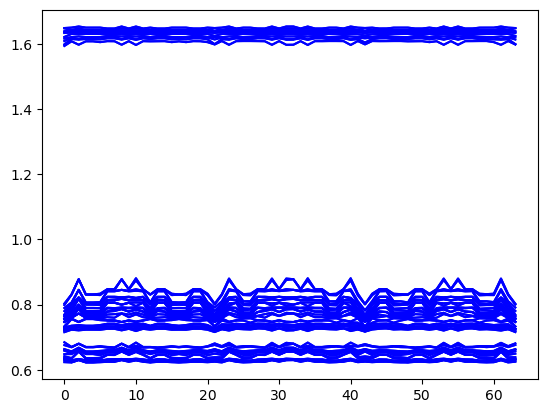

In [13]:
# plt.plot(np.arange(S.shape[0]), S[:, 20: -24], c='b')
plt.plot(np.arange(S.shape[0]), S, c='b')


In [23]:
S.shape

(64, 92)

In [19]:
A.shape

(64, 200, 92)

### Wannier windows

- Distentanglement: -7-15 eV
- Frozen: 2.5-11 eV

### Trial wavefunctions
Number of bands from -7-15 eV = 75

Number of bands from 2.5-11 eV ~ 46

- Mn1 d: 5 (l orbs) x 1 (atoms) x 2 (spins) = 10
- Mn2 d: 5 (l orbs) x 1 (atoms) x 2 (spins) = 10
- Bi p: 3 (l orbs) x 4 (atoms) x 2 (spins) = 24
- Te p: 3 (l orbs) x 8 (atoms) x 2 (spins) = 48

Total number of trial states = 92 (/2 = 46)


- Mn1 s2: 1 (l orbs) x 1 (atoms) x 2 (spins) = 2
- Mn2 s2: 1 (l orbs) x 1 (atoms) x 2 (spins) = 2
- Bi s: 1 (l orbs) x 4 (atoms) x 2 (spins) = 8
- Te s: 1 (l orbs) x 8 (atoms) x 2 (spins) = 16


In [169]:
92/2

46.0

In [ ]:
10 + 10 + 24 + 48 #+ 2+2+8+16

92